In [1]:
import os
import pandas as pd
import nltk
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer
import re
from sklearn.model_selection import KFold
import numpy as np
from nltk.stem import PorterStemmer
import os
import joblib
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)



/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
def init_tokenizer(use_bert=False):
    """Initialize either BERT or NLTK tokenizer"""
    if use_bert:
        return BertTokenizer.from_pretrained('bert-base-cased')
    return None 

def clean_text(text, tokenizer=None):
    """Clean text using either BERT or NLTK tokenization"""
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = str(text).strip()
    
    if tokenizer:  # Using BERT
        tokens = tokenizer.tokenize(text)
    else:  # Using NLTK
        tokens = nltk.word_tokenize(text)
    
    tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
    return ' '.join(tokens)

# Feature extraction for CRF
def extract_features(tokens, position):
    return {
        'word': tokens[position],
        'is_first': position == 0,
        'is_last': position == len(tokens) - 1,
        'is_capitalized': tokens[position][0].isupper(),
        'is_all_caps': tokens[position].isupper(),
        'prefix-1': tokens[position][0],
        'prefix-2': tokens[position][:2],
        'suffix-1': tokens[position][-1],
        'suffix-2': tokens[position][-2:],
        'prev_word': tokens[position - 1] if position > 0 else '',
        'next_word': tokens[position + 1] if position < len(tokens) - 1 else '',
        'has_hyphen': '-' in tokens[position],
        'is_numeric': tokens[position].isdigit(),
        'capitals_inside': tokens[position][1:].islower()
    }

def sentence_to_features(sentence):
    tokens = sentence.split()
    return [extract_features(tokens, i) for i in range(len(tokens))]

def upsample_data(df):
    """Upsample minority class to balance the dataset"""
    # Separate majority and minority classes
    majority = df[df['label'] == 0]
    minority = df[df['label'] == 1]
    
    # Upsample minority class
    minority_upsampled = minority.sample(
        n=len(majority), 
        replace=True, 
        random_state=42
    )
    
    # Combine majority and upsampled minority
    df_upsampled = pd.concat([majority, minority_upsampled])
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Upsampled dataset shape: {df_upsampled.shape}")
    
    return df_upsampled

def preprocess_data(pickle_path, use_bert=False, upsample=True):
    """Preprocess with option for BERT tokenization and upsampling"""
    # Initialize tokenizer
    tokenizer = init_tokenizer(use_bert)
    
    # Load data
    df = pd.read_pickle(pickle_path)
    df = df.dropna(subset=['sentence'])
    
    # Create labels
    df['label'] = df['is_propaganda'].map({'propaganda': 1, 'non-propaganda': 0})
    
    # Clean text with selected tokenizer
    df['cleaned_sentence'] = df['sentence'].apply(lambda x: clean_text(x, tokenizer))
    
    # Apply upsampling if requested
    if upsample:
        df = upsample_data(df)
    
    print(f"Using {'BERT' if use_bert else 'NLTK'} tokenization")
    return df


def prepare_data(df):
    """Prepare data with validation split"""
    # First split into train and temporary test
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Split temporary test into validation and test
    test_df, val_df = train_test_split(temp_df, test_size=0.2, random_state=42)
    
    # Prepare features and labels for all sets
    X_train = [sentence_to_features(sent) for sent in train_df['cleaned_sentence']]
    y_train = [[str(label)] * len(sent.split()) 
               for sent, label in zip(train_df['cleaned_sentence'], train_df['label'])]
    
    X_test = [sentence_to_features(sent) for sent in test_df['cleaned_sentence']]
    y_test = [[str(label)] * len(sent.split()) 
              for sent, label in zip(test_df['cleaned_sentence'], test_df['label'])]
    
    X_val = [sentence_to_features(sent) for sent in val_df['cleaned_sentence']]
    y_val = [[str(label)] * len(sent.split()) 
             for sent, label in zip(val_df['cleaned_sentence'], val_df['label'])]
    
    return X_train, X_test, X_val, y_train, y_test, y_val

def train_model(X_train, X_val, y_train, y_val, num_epochs=10, patience=3):
    """Train model with epochs and early stopping"""
    # Initialize CRF model
    model = CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    
    print("Training CRF model...")
    best_val_f1 = 0
    patience_counter = 0
    best_model = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Train for one iteration
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        
        # Flatten predictions and true labels
        y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
        y_val_flat = [item for sublist in y_val for item in sublist]
        
        # Get validation metrics
        val_report = classification_report(y_val_flat, y_val_pred_flat, output_dict=True)
        val_f1 = val_report['weighted avg']['f1-score']
        
        print(f"Validation F1-Score: {val_f1:.4f}")
        
        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model
            patience_counter = 0
            print("Found new best model!")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")
        
        # Check if to stop early
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break
    
    print("\nTraining complete!")
    return best_model if best_model is not None else model

def cross_validate_model(df, k=5, num_epochs=10, patience=3):
    """Perform k-fold cross validation and return best model"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_scores = []
    best_model = None
    best_f1 = 0
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\nFold {fold + 1}/{k}")
        
        # Split data for this fold
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        # Prepare features and labels
        X_train = [sentence_to_features(sent) for sent in train_fold['cleaned_sentence']]
        y_train = [[str(label)] * len(sent.split()) 
                   for sent, label in zip(train_fold['cleaned_sentence'], train_fold['label'])]
        
        X_val = [sentence_to_features(sent) for sent in val_fold['cleaned_sentence']]
        y_val = [[str(label)] * len(sent.split()) 
                 for sent, label in zip(val_fold['cleaned_sentence'], val_fold['label'])]
        
        # Train model for this fold
        model = train_model(X_train, X_val, y_train, y_val, num_epochs, patience)
        
        # Get fold score
        y_val_pred = model.predict(X_val)
        y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
        y_val_flat = [item for sublist in y_val for item in sublist]
        
        fold_report = classification_report(y_val_flat, y_val_pred_flat, output_dict=True)
        fold_f1 = fold_report['weighted avg']['f1-score']
        fold_scores.append(fold_f1)
        
        # Keep track of best model
        if fold_f1 > best_f1:
            best_f1 = fold_f1
            best_model = model
        
        print(f"Fold {fold + 1} F1-Score: {fold_f1:.4f}")
    
    print(f"\nAverage F1-Score across folds: {sum(fold_scores)/len(fold_scores):.4f}")
    print(f"Best F1-Score: {best_f1:.4f}")
    
    return best_model, fold_scores

def evaluate_model(model, X_test, y_test, X_train=None, y_train=None):
    """Evaluate model on test set and optionally show train metrics"""
    # Test set evaluation
    y_pred = model.predict(X_test)
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    y_test_flat = [item for sublist in y_test for item in sublist]
    
    print("\nTest Set Classification Report:")
    print(classification_report(y_test_flat, y_pred_flat))
    
    # Training set evaluation
    if X_train is not None and y_train is not None:
        y_train_pred = model.predict(X_train)
        y_train_pred_flat = [item for sublist in y_train_pred for item in sublist]
        y_train_flat = [item for sublist in y_train for item in sublist]
        
        print("\nTraining Set Classification Report:")
        print(classification_report(y_train_flat, y_train_pred_flat))
        
        # Check for overfitting
        train_report = classification_report(y_train_flat, y_train_pred_flat, output_dict=True)
        test_report = classification_report(y_test_flat, y_pred_flat, output_dict=True)
        
        train_f1 = train_report['weighted avg']['f1-score']
        test_f1 = test_report['weighted avg']['f1-score']
        
        if train_f1 - test_f1 > 0.1: 
            print("\nWarning: Model might be overfitting!")
            print(f"Training F1: {train_f1:.4f}")
            print(f"Test F1: {test_f1:.4f}")

def classify_text(model, file_path, use_bert=False):
    """Classify text with option for BERT tokenization"""
    tokenizer = init_tokenizer(use_bert)
    
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    
    sentences = [sent.strip() for sent in nltk.sent_tokenize(text)]
    cleaned_sentences = [clean_text(sent, tokenizer) for sent in sentences]
    X_crf = [sentence_to_features(sent) for sent in cleaned_sentences]
    
    predictions = model.predict(X_crf)
    
    results = []
    for i, (sent, pred) in enumerate(zip(sentences, predictions), 1):
        labels = ['O' if label == '0' else 'PROPAGANDA' for label in pred[0]]
        labeled_sentence = ' '.join([f"{word} ({label})" for word, label in zip(sent.split(), labels)])
        results.append(f"{i} {labeled_sentence}")
    
    return '\n'.join(results)

In [ ]:
# 1. Preprocess data
df_slc = preprocess_data('pickled/train_set_SLC.pkl', use_bert=True)

# 2. Prepare data
X_train_slc, X_test_slc, X_val_slc, y_train_slc, y_test_slc, y_val_slc = prepare_data(df_slc)

# 3. Train model with optimization
best_model_slc, fold_scores = cross_validate_model(df_slc, k=5, num_epochs=10, patience=3)

# 4. Evaluate model 
evaluate_model(best_model_slc, X_test_slc, y_test_slc, X_train_slc, y_train_slc)

Original dataset shape: (16297, 6)
Upsampled dataset shape: (23152, 6)
Using BERT tokenization

Fold 1/5
Training CRF model...

Epoch 1/10
Validation F1-Score: 0.8478
Found new best model!

Epoch 2/10
Validation F1-Score: 0.8478
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.8478
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.8478
No improvement. Patience: 3/3
Early stopping triggered after epoch 4

Training complete!
Fold 1 F1-Score: 0.8478

Fold 2/5
Training CRF model...

Epoch 1/10
Validation F1-Score: 0.8501
Found new best model!

Epoch 2/10
Validation F1-Score: 0.8501
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.8501
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.8501
No improvement. Patience: 3/3
Early stopping triggered after epoch 4

Training complete!
Fold 2 F1-Score: 0.8501

Fold 3/5
Training CRF model...

Epoch 1/10
Validation F1-Score: 0.8414
Found new best model!

Epoch 2/10
Validation F1-Score: 0.84

In [4]:
def read_spans_csv(csv_path):
    """
    Read the CSV file containing span information
    """
    return pd.read_csv(csv_path)

def read_labels_file(file_path):
    """
    Read .task-SLC.labels file and create a map of sentence indices to propaganda labels
    """
    sentence_labels = {}
    with open(file_path) as f:
        for line in f:
            line = line.strip()
            if line:
                article_id, sent_idx, label = line.split('\t')
                sentence_labels[int(sent_idx)] = label
    return sentence_labels

def read_article_text(file_path):
    """
    Read the .txt file and split into sentences
    """
    with open(file_path) as f:
        # Split by newlines but keep empty lines to maintain sentence indexing
        return f.read().split('\n')

def get_sentence_index_from_position(sentences, start_index):
    """
    Find which sentence contains the given start index
    """
    current_pos = 0
    for idx, sentence in enumerate(sentences, 1):
        current_pos += len(sentence) + 1
        if start_index < current_pos:
            return idx
    return None


def merge_files(spans_csv_path, base_folder):
    """
    Merges all three files together
    """
    # Read the spans CSV
    spans_df = read_spans_csv(spans_csv_path)
    
    # Add new columns
    spans_df['sentence_label'] = None  # for propaganda/non-propaganda
    spans_df['sentence_text'] = None   # for the full sentence
    
    # Define subfolder paths
    labels_folder = os.path.join(base_folder, 'train-labels-SLC')
    articles_folder = os.path.join(base_folder, 'train-articles')
    
    # Process each article
    for article_id, group in spans_df.groupby('article_id'):
        try:
            # Construct file paths with correct subfolders
            labels_file = os.path.join(labels_folder, f'article{article_id}.task-SLC.labels')
            text_file = os.path.join(articles_folder, f'article{article_id}.txt')
            
            # Read both files
            sentence_labels = read_labels_file(labels_file)
            sentences = read_article_text(text_file)
            
            # Process each span in this article
            for idx, row in group.iterrows():
                # Find which sentence this span belongs to
                sent_idx = get_sentence_index_from_position(sentences, row['start_index'])
                
                if sent_idx is not None:
                    # Add the propaganda/non-propaganda label
                    spans_df.at[idx, 'sentence_label'] = sentence_labels.get(sent_idx, 'unknown')
                    # Add the sentence text
                    spans_df.at[idx, 'sentence_text'] = sentences[sent_idx - 1]
                    
        except Exception as e:
            print(f"Error processing article {article_id}: {str(e)}")
            continue
    
    return spans_df

In [ ]:
spans_csv_path = 'data/diss_data_correct.csv'
base_folder = 'datasets'

result_df = merge_files(spans_csv_path, base_folder)

display(result_df)


,Unnamed: 0,article_id,start_index,end_index,article_text,target_text,technique,sentence_label,sentence_text
0,6,780619695,44,62,"Francis and Farrell’s 'Sinod' on the Youth, #S...",#StopThe Synod2018,Slogans,propaganda,"Francis and Farrell’s 'Sinod' on the Youth, #S..."
1,7,780619695,3735,3740,"Francis and Farrell’s 'Sinod' on the Youth, #S...",dirty,Loaded_Language,propaganda,Here is the dirty secret that is now emerging.
2,8,780619695,6301,6314,"Francis and Farrell’s 'Sinod' on the Youth, #S...",#StopTheSynod,Slogans,propaganda,Editor's Note: The Remnant has lunched its own...
3,10,780619695,1935,1959,"Francis and Farrell’s 'Sinod' on the Youth, #S...",intrinsically disordered,Loaded_Language,propaganda,How inconvenient that a global homosexual cler...
4,11,780619695,4123,4129,"Francis and Farrell’s 'Sinod' on the Youth, #S...",sordid,Loaded_Language,propaganda,The personal wreckage brutally portrayed in th...
...,...,...,...,...,...,...,...,...,...
5453,6035,756114837,3938,3947,WHO Prepares For “Worst Case” As Congo Ebola O...,cimated W,Loaded_Language,propaganda,"Ebola, a haemorrhagic fever, killed at least 1..."
5454,6036,704856340,4007,4187,New Audio From The Night Of The Las Vegas Mass...,Slowly but surely we are beginning to see the ...,Doubt,propaganda,Slowly but surely we are beginning to see the ...
5455,6037,704856340,4107,4187,New Audio From The Night Of The Las Vegas Mass...,authorities desperately trying to prevent it f...,Flag-Waving,propaganda,Slowly but surely we are beginning to see the ...
5456,6038,704856340,4187,4326,New Audio From The Night Of The Las Vegas Mass...,"Sadly, the picture emerging is one that includ...",Doubt,propaganda,"Sadly, the picture emerging is one that includ..."


In [6]:
final_FLC_df = result_df.drop(['Unnamed: 0'], axis=1)
#final_FLC_df = result_df[result_df['sentence_label'] == 'propaganda'] not removing non-propaganda sentences as some have technique labels attached
display(final_FLC_df)

final_FLC_df.to_csv('data/FLC_df.csv', index=False)

,article_id,start_index,end_index,article_text,target_text,technique,sentence_label,sentence_text
0,780619695,44,62,"Francis and Farrell’s 'Sinod' on the Youth, #S...",#StopThe Synod2018,Slogans,propaganda,"Francis and Farrell’s 'Sinod' on the Youth, #S..."
1,780619695,3735,3740,"Francis and Farrell’s 'Sinod' on the Youth, #S...",dirty,Loaded_Language,propaganda,Here is the dirty secret that is now emerging.
2,780619695,6301,6314,"Francis and Farrell’s 'Sinod' on the Youth, #S...",#StopTheSynod,Slogans,propaganda,Editor's Note: The Remnant has lunched its own...
3,780619695,1935,1959,"Francis and Farrell’s 'Sinod' on the Youth, #S...",intrinsically disordered,Loaded_Language,propaganda,How inconvenient that a global homosexual cler...
4,780619695,4123,4129,"Francis and Farrell’s 'Sinod' on the Youth, #S...",sordid,Loaded_Language,propaganda,The personal wreckage brutally portrayed in th...
...,...,...,...,...,...,...,...,...
5453,756114837,3938,3947,WHO Prepares For “Worst Case” As Congo Ebola O...,cimated W,Loaded_Language,propaganda,"Ebola, a haemorrhagic fever, killed at least 1..."
5454,704856340,4007,4187,New Audio From The Night Of The Las Vegas Mass...,Slowly but surely we are beginning to see the ...,Doubt,propaganda,Slowly but surely we are beginning to see the ...
5455,704856340,4107,4187,New Audio From The Night Of The Las Vegas Mass...,authorities desperately trying to prevent it f...,Flag-Waving,propaganda,Slowly but surely we are beginning to see the ...
5456,704856340,4187,4326,New Audio From The Night Of The Las Vegas Mass...,"Sadly, the picture emerging is one that includ...",Doubt,propaganda,"Sadly, the picture emerging is one that includ..."


In [7]:
def prepare_bio_tags(sentence, target_text, technique):
    """Convert target spans into BIO tags with O tags for non-propaganda text"""
    words = [w.strip() for w in nltk.word_tokenize(sentence)]
    target_words = [w.strip() for w in nltk.word_tokenize(target_text)]
    
    # Initialize all tokens as non-propaganda with 'O' tags
    bio_tags = ['O'] * len(words)
    
    # Find target words in sentence
    target_text_lower = ' '.join(target_words).lower()
    for i in range(len(words) - len(target_words) + 1):
        if ' '.join(words[i:i+len(target_words)]).lower() == target_text_lower:
            # Mark first token as B-technique
            bio_tags[i] = f'B-{technique}'
            # Mark remaining tokens as I-technique
            for j in range(1, len(target_words)):
                bio_tags[i+j] = f'I-{technique}'
            break
                
    return words, bio_tags

def extract_features(tokens, position):
    """Extract features for CRF"""
    stemmer = PorterStemmer()
    word = tokens[position].strip()
    stemmed_word = stemmer.stem(word)

    return {
        'word': word,
        'stemmed_word': stemmed_word,
        'is_first': position == 0,
        'is_last': position == len(tokens) - 1,
        'is_capitalized': tokens[position][0].isupper(),
        'is_all_caps': tokens[position].isupper(),
        'prefix-1': tokens[position][0],
        'prefix-2': tokens[position][:2],
        'suffix-1': tokens[position][-1],
        'suffix-2': tokens[position][-2:],
        'prev_word': tokens[position - 1] if position > 0 else '',
        'next_word': tokens[position + 1] if position < len(tokens) - 1 else '',
        'has_hyphen': '-' in tokens[position],
        'is_numeric': tokens[position].isdigit(),
        'capitals_inside': tokens[position][1:].islower()
    }

def preprocess_propaganda_data(df):
    """Preprocess data for propaganda technique detection"""
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    
    X = []
    y = []
    
    total = len(df)
    print(f"Processing {total} sentences...")
    
    df = df.reset_index(drop=True)
    processed = 0
    
    for idx, row in df.iterrows():
        processed += 1
        #if processed % 100 == 0:
            #print(f"Progress: {processed}/{total}")
            
        try:
            # Get BIO tags and words
            words, bio_tags = prepare_bio_tags(
                row['sentence_text'], 
                row['target_text'], 
                row['technique']
            )
            
            # Extract features for each token
            sentence_features = [extract_features(words, i) for i in range(len(words))]
            
            X.append(sentence_features)
            y.append(bio_tags)
            
        except Exception as e:
            print(f"Error processing sentence {idx}: {row['sentence_text'][:100]}...")
            print(f"Error: {str(e)}")
            continue
    
    #print(f"\nProcessing Summary:")
    #print(f"Total rows in split: {total}")
    #print(f"Successfully processed: {len(X)}")
    #print(f"Success rate: {(len(X)/total)*100:.2f}%")
    
    return X, y

def upsample_technique_data(df):
    """Upsample minority techniques to balance the dataset"""
    # Get technique distribution
    technique_counts = df['technique'].value_counts()
    max_count = technique_counts.max()
    
    # Upsample each minority technique
    dfs = []
    for technique in technique_counts.index:
        technique_df = df[df['technique'] == technique]
        upsampled = technique_df.sample(
            n=max_count,
            replace=True,
            random_state=42
        )
        dfs.append(upsampled)
    
    # Combine all upsampled techniques
    df_upsampled = pd.concat(dfs)
    
    print(f"Original dataset shape: {df.shape}")
    print(f"Upsampled dataset shape: {df_upsampled.shape}")
    print("\nTechnique distribution after upsampling:")
    print(df_upsampled['technique'].value_counts())
    
    return df_upsampled

def prepare_technique_data(df, upsample=True):
    """Prepare data for propaganda technique detection with validation split and upsampling"""
    print(f"\nPreparing data for technique detection:")
    
    if upsample:
        df = upsample_technique_data(df)
    
    # First split into train and temporary test
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Split temporary test into validation and test
    test_df, val_df = train_test_split(temp_df, test_size=0.2, random_state=42)
    
    # Process each set
    print("\nProcessing training data...")
    X_train, y_train = preprocess_propaganda_data(train_df)
    
    print("\nProcessing test data...")
    X_test, y_test = preprocess_propaganda_data(test_df)
    
    print("\nProcessing validation data...")
    X_val, y_val = preprocess_propaganda_data(val_df)
    
    return X_train, X_test, X_val, y_train, y_test, y_val


def train_propaganda_model(X_train, X_val, y_train, y_val, num_epochs=10, patience=3):
    """Train CRF model"""
    model = CRF(
        algorithm='lbfgs',
        c1=0.1,
        c2=0.1,
        max_iterations=100,
        all_possible_transitions=True
    )
    
    print("Training propaganda technique detection model...")
    best_val_f1 = 0
    patience_counter = 0
    best_model = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        
        # Flatten predictions and true labels
        y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
        y_val_flat = [item for sublist in y_val for item in sublist]
        
        val_report = classification_report(y_val_flat, y_val_pred_flat, output_dict=True)
        val_f1 = val_report['weighted avg']['f1-score']
        
        print(f"Validation F1-Score: {val_f1:.4f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model
            patience_counter = 0
            print("Found new best model!")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch + 1}")
            break
    
    return best_model if best_model is not None else model

def cross_validate_model_flc(df, k=5, num_epochs=10, patience=3):
    """Perform k-fold cross validation for FLC task"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_scores = []
    best_model = None
    best_f1 = 0
    
    # Prepare full dataset features and labels using FLC preprocessing
    X, y = preprocess_propaganda_data(df)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{k}")
        
        # Split features and labels for this fold
        X_train = [X[i] for i in train_idx]
        y_train = [y[i] for i in train_idx]
        X_val = [X[i] for i in val_idx]
        y_val = [y[i] for i in val_idx]
        
        # Train model using FLC training function
        model = train_propaganda_model(X_train, X_val, y_train, y_val, num_epochs, patience)
        
        # Evaluate using FLC metrics
        y_val_pred = model.predict(X_val)
        y_val_pred_flat = [item for sublist in y_val_pred for item in sublist]
        y_val_flat = [item for sublist in y_val for item in sublist]
        
        fold_report = classification_report(y_val_flat, y_val_pred_flat, output_dict=True)
        fold_f1 = fold_report['weighted avg']['f1-score']
        fold_scores.append(fold_f1)
        
        if fold_f1 > best_f1:
            best_f1 = fold_f1
            best_model = model
            
        print(f"Fold {fold + 1} F1-Score: {fold_f1:.4f}")
    
    print(f"\nAverage F1-Score across folds: {sum(fold_scores)/len(fold_scores):.4f}")
    print(f"Best F1-Score: {best_f1:.4f}")
    
    return best_model, fold_scores

def evaluate_model(model, X_test, y_test, X_train=None, y_train=None):
    """Evaluate model performance with consolidated technique labels"""
    def consolidate_bio_labels(labels):
        # Remove BIO prefixes and keep unique technique names
        return [label.split('-')[-1] if '-' in label else label for label in labels]
    
    # Test set evaluation
    y_pred = model.predict(X_test)
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    y_test_flat = [item for sublist in y_test for item in sublist]
    
    # Consolidate labels
    y_pred_flat = consolidate_bio_labels(y_pred_flat)
    y_test_flat = consolidate_bio_labels(y_test_flat)

    print("\nTest Set Classification Report:")
    print(classification_report(y_test_flat, y_pred_flat, zero_division='warn'))

    # Training set evaluation if provided
    if X_train is not None and y_train is not None:
        y_train_pred = model.predict(X_train)
        y_train_pred_flat = [item for sublist in y_train_pred for item in sublist]
        y_train_flat = [item for sublist in y_train for item in sublist]
        
        # Consolidate training labels
        y_train_pred_flat = consolidate_bio_labels(y_train_pred_flat)
        y_train_flat = consolidate_bio_labels(y_train_flat)

        print("\nTraining Set Classification Report:")
        print(classification_report(y_train_flat, y_train_pred_flat, zero_division='warn'))

        # Check for overfitting
        train_report = classification_report(y_train_flat, y_train_pred_flat, output_dict=True, zero_division='warn')
        test_report = classification_report(y_test_flat, y_pred_flat, output_dict=True, zero_division='warn')

        train_f1 = train_report['weighted avg']['f1-score']
        test_f1 = test_report['weighted avg']['f1-score']

        if train_f1 - test_f1 > 0.1:
            print("\nWarning: Model might be overfitting!")
            print(f"Training F1: {train_f1:.4f}")
            print(f"Test F1: {test_f1:.4f}")


In [ ]:
# Load data
df_flc = pd.read_csv('data/FLC_df.csv')
    
# Split and prepare the data
X_train_flc, X_test_flc, X_val_flc, y_train_flc, y_test_flc, y_val_flc = prepare_technique_data(df_flc)

# Train the model
best_model_flc, fold_scores_flc = cross_validate_model_flc(df_flc, k=10)
    
# Evaluate the model
evaluate_model(best_model_flc, X_test_flc, y_test_flc, X_train_flc, y_train_flc)


Preparing data for technique detection:
Original dataset shape: (5458, 8)
Upsampled dataset shape: (27482, 8)

Technique distribution after upsampling:
technique
Loaded_Language                       2114
Name_Calling,Labeling                 2114
Doubt                                 2114
Exaggeration,Minimisation             2114
Flag-Waving                           2114
Appeal_to_fear-prejudice              2114
Causal_Oversimplification             2114
Slogans                               2114
Appeal_to_Authority                   2114
Black-and-White_Fallacy               2114
Whataboutism,straw man,red herring    2114
Thought-terminating_Cliches           2114
Bandwagon,reductio ad hitlerum        2114
Name: count, dtype: int64

Processing training data...
Processing 21985 sentences...

Processing test data...
Processing 4397 sentences...

Processing validation data...
Processing 1100 sentences...
Processing 5458 sentences...

Fold 1/10
Training propaganda technique detection

/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6957
Found new best model!

Epoch 2/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6957
No improvement. Patience: 1/3

Epoch 3/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6957
No improvement. Patience: 2/3

Epoch 4/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6957
No improvement. Patience: 3/3
Early stopping triggered after epoch 4


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 3 F1-Score: 0.6957

Fold 4/10
Training propaganda technique detection model...

Epoch 1/10
Validation F1-Score: 0.6938
Found new best model!

Epoch 2/10
Validation F1-Score: 0.6938
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.6938
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.6938
No improvement. Patience: 3/3
Early stopping triggered after epoch 4
Fold 4 F1-Score: 0.6938

Fold 5/10
Training propaganda technique detection model...

Epoch 1/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6714
Found new best model!

Epoch 2/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6714
No improvement. Patience: 1/3

Epoch 3/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6714
No improvement. Patience: 2/3

Epoch 4/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.6714
No improvement. Patience: 3/3
Early stopping triggered after epoch 4


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 5 F1-Score: 0.6714

Fold 6/10
Training propaganda technique detection model...

Epoch 1/10
Validation F1-Score: 0.7001
Found new best model!

Epoch 2/10
Validation F1-Score: 0.7001
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.7001
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.7001
No improvement. Patience: 3/3
Early stopping triggered after epoch 4
Fold 6 F1-Score: 0.7001

Fold 7/10
Training propaganda technique detection model...

Epoch 1/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.7154
Found new best model!

Epoch 2/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.7154
No improvement. Patience: 1/3

Epoch 3/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.7154
No improvement. Patience: 2/3

Epoch 4/10


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation F1-Score: 0.7154
No improvement. Patience: 3/3
Early stopping triggered after epoch 4


/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raylesser/miniforge3/envs/rl_env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Fold 7 F1-Score: 0.7154

Fold 8/10
Training propaganda technique detection model...

Epoch 1/10
Validation F1-Score: 0.6912
Found new best model!

Epoch 2/10
Validation F1-Score: 0.6912
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.6912
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.6912
No improvement. Patience: 3/3
Early stopping triggered after epoch 4
Fold 8 F1-Score: 0.6912

Fold 9/10
Training propaganda technique detection model...

Epoch 1/10
Validation F1-Score: 0.6894
Found new best model!

Epoch 2/10
Validation F1-Score: 0.6894
No improvement. Patience: 1/3

Epoch 3/10
Validation F1-Score: 0.6894
No improvement. Patience: 2/3

Epoch 4/10
Validation F1-Score: 0.6894
No improvement. Patience: 3/3
Early stopping triggered after epoch 4
Fold 9 F1-Score: 0.6894

Fold 10/10
Training propaganda technique detection model...

Epoch 1/10
Validation F1-Score: 0.6889
Found new best model!

Epoch 2/10
Validation F1-Score: 0.6889
No improvement. Patienc

In [ ]:
# Create models directory
os.makedirs('models/', exist_ok=True)
    
# Save SLC model
slc_path = os.path.join('models/', 'slc_model.joblib')
joblib.dump(best_model_slc, slc_path)
    
# Save FLC model
flc_path = os.path.join('models/', 'flc_model.joblib')
joblib.dump(best_model_flc, flc_path)
    
print(f"Models saved in {'models/'}")


Models saved in models/


In [10]:
def clean_text(text):
    # HTML tags removal
    text = re.sub(r'<[^>]+>', '', str(text))
    
    # Standardize quotes and special characters
    replacements = {
        '\u201c': '"',    # left double quote
        '\u201d': '"',    # right double quote
        '\u2018': "'",    # left single quote
        '\u2019': "'",    # right single quote/apostrophe
        '\u2013': '-',    # en dash
        '\u2014': '-',    # em dash
        '\u2026': '...',  # ellipsis
        '\xa0': ' ',      # non-breaking space
        '&quot;': '"',    # HTML quote
        '&amp;': '&',     # HTML ampersand
        '&lt;': '<',      # HTML less than
        '&gt;': '>'       # HTML greater than
    }
    
    for old, new in replacements.items():
        text = str(text).replace(old, new)
    
    # Normalize whitespace and line breaks
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single space
    text = re.sub(r'\n\s*\n', '\n', text)  # Multiple line breaks to single
    text = text.strip()  # Remove leading/trailing whitespace
    
    # Handle non-ASCII text while preserving common symbols
    text = ''.join(char for char in text if char.isascii() or char in {'€', '£', '¥', '°', '²', '³'})
    
    return text

def remove_duplicate_lines(text):
    # Split into lines
    lines = str(text).split('\n')
    # Remove duplicates while preserving order
    seen = set()
    unique_lines = [line for line in lines if not (line in seen or seen.add(line))]
    # Join back into text
    return '\n'.join(unique_lines)


# Load CSVs
bbc_articles1 = pd.read_csv('bbc_articles_3.csv')
bbc_articles2 = pd.read_csv('bbc_articles_remaining.csv')
guardian_articles = pd.read_csv('guardian_articles.csv')

# Clean text columns in each dataframe
text_columns = ['title', 'content']  # adjust column names as needed
for df in [bbc_articles1, bbc_articles2, guardian_articles]:
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].apply(clean_text)

# Apply to content column of each dataframe
for df in [bbc_articles1, bbc_articles2, guardian_articles]:
    if 'content' in df.columns:
        df['content'] = df['content'].apply(remove_duplicate_lines)


bbc_combined = pd.concat([bbc_articles1, bbc_articles2], ignore_index=True)
bbc_combined['source'] = 'BBC'
guardian_articles['source'] = 'Guardian'
#display(bbc_combined.head())
#display(guardian_articles.head())

all_articles = pd.concat([bbc_combined, guardian_articles], ignore_index=True)
#display(all_articles)

all_articles['article_id'] = all_articles.index
display(all_articles.head())

In [11]:
# Using RoBERTa which generally performs better on topic classification
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model = AutoModel.from_pretrained("roberta-base")

def mean_pooling(model_output, attention_mask):
    """Perform mean pooling on token embeddings."""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def get_text_embeddings(text):
    """Get embeddings for input text."""
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    return mean_pooling(outputs, inputs['attention_mask'])

# Define relevant topics and their associated keywords
TOPIC_KEYWORDS = {
    'primary': [
        'israel', 'palestine', 'gaza', 'hamas', 'idf', 'west bank', 
        'jerusalem', 'tel aviv', 'palestinian', 'israeli'
    ],
    'secondary': [
        'conflict', 'war', 'attack', 'missile', 'rocket', 'ceasefire',
        'peace', 'negotiation', 'military', 'civilian', 'casualties',
        'humanitarian', 'settlement', 'border', 'security', 'middle east'
    ],
    'context': [
        'october 7', 'hostage', 'militant', 'refugee', 'aid',
        'violence', 'defense', 'prime minister', 'death toll',
        'diplomatic', 'un security council', 'resolution'
    ]
}

def analyze_article(text, article_num):
    """
    Analyzes if an article discusses the Israel-Palestine conflict.
    Returns "YES" if the article is relevant, "NO" otherwise.
    """
    # Initialize result as NO by default
    result = "NO"
    
    # Handle invalid text
    if not isinstance(text, str):
        print(f"Article number {article_num}: [Invalid text format]")
        print(f"Analysis: {result}")
        return result
    
    # Get and print first line
    first_line = text.split('\n')[0][:100] + "..."
    print(f"Article number {article_num}: {first_line}")
    
    text = text.lower()
    
    # 1. Keyword Analysis
    primary_matches = sum(1 for kw in TOPIC_KEYWORDS['primary'] if re.search(r'\b' + kw + r'\b', text))
    secondary_matches = sum(1 for kw in TOPIC_KEYWORDS['secondary'] if re.search(r'\b' + kw + r'\b', text))
    context_matches = sum(1 for kw in TOPIC_KEYWORDS['context'] if re.search(r'\b' + kw + r'\b', text))
    
    # If we have strong keyword evidence, classify as YES
    if (primary_matches >= 2 and (secondary_matches + context_matches) >= 1) or \
       (primary_matches >= 1 and (secondary_matches + context_matches) >= 3):
        result = "YES"
        print(f"Analysis: {result}")
        return result
    
    # If we have almost no keyword matches, keep as NO
    if primary_matches == 0 and secondary_matches <= 1 and context_matches == 0:
        print(f"Analysis: {result}")
        return result
    
    # 2. Semantic Analysis for borderline cases
    # Prepare reference text
    reference_text = """
    This article discusses the ongoing situation between Israel and Palestine, 
    including events in Gaza and the wider conflict in the region.
    """
    
    # Get embeddings
    text_sample = text[:512]  # Take first 512 chars for semantic analysis
    article_embedding = get_text_embeddings(text_sample)
    reference_embedding = get_text_embeddings(reference_text)
    
    # Calculate semantic similarity
    similarity = F.cosine_similarity(article_embedding, reference_embedding)
    
    # Determine final classification using both keyword counts and semantic similarity
    total_keywords = primary_matches + (0.5 * secondary_matches) + (0.5 * context_matches)
    semantic_score = similarity.item()
    
    # Combined scoring with adjusted thresholds
    if (semantic_score > 0.6 and total_keywords >= 1.5) or \
       (semantic_score > 0.5 and total_keywords >= 2.5) or \
       (semantic_score > 0.4 and total_keywords >= 3.5):
        result = "YES"
    
    print(f"Analysis: {result}")
    return result

# Process the existing articles DataFrame
all_articles['analysis'] = all_articles['content'].apply(lambda x: analyze_article(x, all_articles.index.get_loc(all_articles[all_articles['content'] == x].index[0]) + 1))

print("\nProcessing complete.")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Article number 1: Lebanese people have been returning to their homes following the ceasefire agreement The latest exch...
Analysis: YES
Article number 2: Women leaving the education colleges on Tuesday Women training as midwives and nurses in Afghanistan...
Analysis: NO
Article number 3: Mohammed al-Halabi is one of thousands of Palestinians living on Gaza's beaches The beaches of Gaza ...
Analysis: YES
Article number 4: Israeli soldiers on patrol in northern Israel, near the border with Lebanon Deadly Israeli air strik...
Analysis: YES
Article number 5: She fled Israeli bombing four times. It still found her Rihab Faour fled her home. Then she fled aga...
Analysis: YES
Article number 6: The biggest UN agency providing aid to Palestinians has said it is suspending deliveries through the...
Analysis: YES
Article number 7: The crater left behind by the massive Israeli air strike that killed Hassan Nasrallah was lit up in ...
Analysis: YES
Article number 8: The wreckage of a car seen foll

In [12]:
# Create new dataframe with sentence-level rows
all_articles_split = []

for _, row in all_articles.iterrows():
    # Split content into sentences
    sentences = nltk.sent_tokenize(row['content'])
    
    # Create a row for each sentence with article metadata
    for sentence_id, sentence in enumerate(sentences, 1):
        new_row = row.copy()  # Copy all columns from original
        new_row['sentence'] = sentence
        new_row['sentence_id'] = sentence_id
        all_articles_split.append(new_row)

# Convert to dataframe
final_article_df = pd.DataFrame(all_articles_split)
display(final_article_df)

,date,title,link,content,topic_page,source,article_id,analysis,sentence,sentence_id
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Lebanese people have been returning to their h...,1
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,The latest exchange of fire between Israel and...,2
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Hours after Hezbollah fired two mortar shells ...,3
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Nine people were killed in two villages in sou...,4
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Yesterday was the most dangerous moment for th...,5
...,...,...,...,...,...,...,...,...,...,...
2786,2024-07-14 15:32:40+00:00,David Lammy to call for Gaza ceasefire in talk...,https://www.theguardian.com/politics/article/2...,David Lammy is to call for an immediate ceasef...,West Bank,Guardian,2786,YES,"In Israel, Lammy will also meet the Israeli pr...",15
2786,2024-07-14 15:32:40+00:00,David Lammy to call for Gaza ceasefire in talk...,https://www.theguardian.com/politics/article/2...,David Lammy is to call for an immediate ceasef...,West Bank,Guardian,2786,YES,The foreign secretary will say there are more ...,16
2786,2024-07-14 15:32:40+00:00,David Lammy to call for Gaza ceasefire in talk...,https://www.theguardian.com/politics/article/2...,David Lammy is to call for an immediate ceasef...,West Bank,Guardian,2786,YES,The government has stopped short of saying the...,17
2786,2024-07-14 15:32:40+00:00,David Lammy to call for Gaza ceasefire in talk...,https://www.theguardian.com/politics/article/2...,David Lammy is to call for an immediate ceasef...,West Bank,Guardian,2786,YES,Lammy said he would acknowledge the recognitio...,18


In [13]:
def process_dataframe_with_models(df, model_slc, model_flc):
    # Step 1: Process with SLC model
    df['label'] = df.apply(lambda row: classify_sentence(
        row['content'], 
        row['sentence'], 
        model_slc
    ), axis=1)
    
    # Create new dataframe for fragments
    fragment_rows = []
    
    # Process propaganda sentences with FLC model
    propaganda_rows = df[df['label'] == 'propaganda'].copy()
    
    for _, row in propaganda_rows.iterrows():
        fragments = extract_fragments(
            row['sentence'],
            model_flc
        )
        
        # Create new row for each fragment
        for fragment in fragments:
            new_row = row.copy()
            new_row['fragment'] = fragment['text']
            new_row['technique'] = fragment['technique']
            fragment_rows.append(new_row)
    
    # Convert fragment rows to dataframe
    fragments_df = pd.DataFrame(fragment_rows)
    
    # Keep all original rows and add fragments as additional rows
    final_df = pd.concat([
        df,
        fragments_df
    ]).reset_index(drop=True)
    
    return final_df

def classify_sentence(content, sentence, model):
    features = sentence_to_features(sentence)
    prediction = model.predict([features])[0]
    # Use any() to check if any element equals '1'
    return 'propaganda' if '1' in prediction else 'non-propaganda'

def extract_fragments(sentence, model):
    features = sentence_to_features(sentence)
    predictions = model.predict([features])[0]
    
    fragments = []
    current_fragment = {'text': '', 'technique': None}
    
    words = sentence.split()
    for word, pred in zip(words, predictions):
        if pred.startswith('B-'):
            if current_fragment['text']:
                fragments.append(current_fragment)
            current_fragment = {
                'text': word,
                'technique': pred.split('-')[1]
            }
        elif pred.startswith('I-'):
            current_fragment['text'] += f' {word}'
    
    if current_fragment['text']:
        fragments.append(current_fragment)
        
    return fragments

# Load the saved models
model_slc = joblib.load('models/slc_model.joblib')
model_flc = joblib.load('models/flc_model.joblib')

processed_df = process_dataframe_with_models(final_article_df, model_slc, model_flc)



In [14]:
display(processed_df)

,date,title,link,content,topic_page,source,article_id,analysis,sentence,sentence_id,label,fragment,technique
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Lebanese people have been returning to their h...,1,non-propaganda,NaN,NaN
1,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,The latest exchange of fire between Israel and...,2,non-propaganda,NaN,NaN
2,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Hours after Hezbollah fired two mortar shells ...,3,non-propaganda,NaN,NaN
3,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Nine people were killed in two villages in sou...,4,non-propaganda,NaN,NaN
4,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Yesterday was the most dangerous moment for th...,5,non-propaganda,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141624,2024-08-08 09:42:55+00:00,'We don't want to live in a prison': grief and...,https://www.theguardian.com/world/article/2024...,There is no light at night in the Nur Shams re...,West Bank,Guardian,2776,YES,Gas canisters to be used for making improvised...,10,propaganda,improvised explosive devices (IEDs) are not hi...,Loaded_Language
141625,2024-08-07 17:00:10+00:00,US support for Israel is collapsing. And Aipac...,https://www.theguardian.com/commentisfree/arti...,"On Tuesday night, Representative Cori Bush los...",West Bank,Guardian,2777,YES,"In the US, politicians kissed babies, petted d...",11,propaganda,"kissed babies, petted dogs, loved baseball and...",Loaded_Language
141626,2024-08-07 17:00:10+00:00,US support for Israel is collapsing. And Aipac...,https://www.theguardian.com/commentisfree/arti...,"On Tuesday night, Representative Cori Bush los...",West Bank,Guardian,2777,YES,Israel's horrific month-and-a-half-long war on...,20,propaganda,horrific month-and-a-half-long war on Gaza whi...,Loaded_Language
141627,2024-08-07 17:00:10+00:00,US support for Israel is collapsing. And Aipac...,https://www.theguardian.com/commentisfree/arti...,"On Tuesday night, Representative Cori Bush los...",West Bank,Guardian,2777,YES,Not only is this war so much more destructive ...,26,propaganda,Not only is this war so much more destructive ...,Doubt


In [15]:
# Create a copy of the original dataframe
final_df = processed_df.copy()


In [16]:
# First deduplicate sentences within each article
unique_sentences_df = final_df.drop_duplicates(['article_id', 'sentence_id'])

# Calculate percentage of propaganda labels per article_id
article_propaganda = (unique_sentences_df
                     .groupby('article_id')['label']
                     .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                     .reset_index(name='article_propaganda'))

# Calculate overall propaganda percentage across all unique sentences
overall_propaganda = article_propaganda['article_propaganda'].mean()

# Calculate percentage of propaganda labels per source using unique sentences
source_propaganda = (unique_sentences_df
                    .groupby('source')['label']
                    .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                    .reset_index(name='source_propaganda'))

# Calculate percentage of propaganda labels for analysis='YES' rows using unique sentences
analysis_propaganda_yes = (unique_sentences_df[unique_sentences_df['analysis'] == 'YES']
                         .groupby('source')['label']
                         .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                         .reset_index(name='analysis_propaganda_yes'))

analysis_propaganda_no = (unique_sentences_df[unique_sentences_df['analysis'] == 'NO']
                        .groupby('source')['label']
                        .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                        .reset_index(name='analysis_propaganda_no'))

# Calculate percentage of propaganda labels per topic_page using unique sentences
topic_propaganda = (unique_sentences_df
                   .groupby('topic_page')['label']
                   .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                   .reset_index(name='topic_propaganda'))

# Merge all calculations into the dataframe
final_df = final_df.drop(columns=['article_propaganda', 'source_propaganda', 'analysis_propaganda_yes', 'analysis_propaganda_no', 'topic_propaganda'], errors='ignore')
final_df = final_df.merge(article_propaganda, on='article_id', how='left')
final_df = final_df.merge(source_propaganda, on='source', how='left')
final_df = final_df.merge(analysis_propaganda_yes, on='source', how='left')
final_df = final_df.merge(analysis_propaganda_no, on='source', how='left')
final_df = final_df.merge(topic_propaganda, on='topic_page', how='left')

# Add overall propaganda as a constant column
final_df['overall_propaganda'] = overall_propaganda
display(final_df.head())


,date,title,link,content,topic_page,source,article_id,analysis,sentence,sentence_id,label,fragment,technique,article_propaganda,source_propaganda,analysis_propaganda_yes,analysis_propaganda_no,topic_propaganda,overall_propaganda
0,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Lebanese people have been returning to their h...,1,non-propaganda,NaN,NaN,14.285714,26.872375,26.924322,24.868594,27.129565,26.963815
1,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,The latest exchange of fire between Israel and...,2,non-propaganda,NaN,NaN,14.285714,26.872375,26.924322,24.868594,27.129565,26.963815
2,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Hours after Hezbollah fired two mortar shells ...,3,non-propaganda,NaN,NaN,14.285714,26.872375,26.924322,24.868594,27.129565,26.963815
3,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Nine people were killed in two villages in sou...,4,non-propaganda,NaN,NaN,14.285714,26.872375,26.924322,24.868594,27.129565,26.963815
4,2024-12-03 16:50:48.459000+00:00,Israeli and Hezbollah strikes test limits of c...,https://www.bbc.co.uk/news/articles/c98ly11k9rwo,Lebanese people have been returning to their h...,Gaza,BBC,0,YES,Yesterday was the most dangerous moment for th...,5,non-propaganda,NaN,NaN,14.285714,26.872375,26.924322,24.868594,27.129565,26.963815


In [17]:
source_summary = (unique_sentences_df
                 .groupby('source')
                 .agg({
                     'label': lambda x: (x == 'propaganda').sum() / len(x) * 100,
                     'article_id': 'nunique',
                     'sentence_id': 'count'
                 })
                 .rename(columns={
                     'label': 'propaganda_percentage',
                     'article_id': 'total_articles',
                     'sentence_id': 'total_sentences'
                 })
                 .round(2)
                 .sort_values('propaganda_percentage', ascending=False))

display(source_summary)


,propaganda_percentage,total_articles,total_sentences
source,,,
Guardian,27.98,501,19510
BBC,26.87,2286,120462


In [18]:
# Create separate summaries for BBC and guardian
bbc_summary = (unique_sentences_df[unique_sentences_df['source'] == 'BBC']
              .groupby('topic_page')['label']
              .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
              .reset_index(name='BBC')
              .sort_values('BBC', ascending=False))

guardian_summary = (unique_sentences_df[unique_sentences_df['source'] == 'Guardian']
                  .groupby('topic_page')['label']
                  .apply(lambda x: (x == 'propaganda').sum() / len(x) * 100)
                  .reset_index(name='Guardian')
                  .sort_values('Guardian', ascending=False))

# Merge them into one table with outer join to keep all topics
combined_summary = bbc_summary.merge(guardian_summary, on='topic_page', how='outer')

# Add average column and sort by it in descending order
combined_summary['Average'] = combined_summary[['BBC', 'Guardian']].mean(axis=1)
combined_summary = combined_summary.sort_values('Average', ascending=False)

# Display the combined table
display(combined_summary)


,topic_page,BBC,Guardian,Average
4,Middle East,NaN,30.595483,30.595483
1,Hamas,26.674970,29.986505,28.330737
5,Palestine,27.913864,28.336756,28.125310
0,Gaza,26.852627,29.209677,28.031152
6,West Bank,25.512195,26.985447,26.248821
3,Israel,27.387215,25.017182,26.202199
2,Hezbollah,26.040649,22.964960,24.502804


In [19]:
# Calculate techniques by source as percentages
technique_by_source = (final_df.groupby(['technique', 'source'])['label']
                      .count().unstack(fill_value=0)
                      .apply(lambda x: x/x.sum()*100).round(2))

# Add average column for techniques
technique_by_source['Average'] = technique_by_source.mean(axis=1)

# Sort by average in descending order
technique_by_source = technique_by_source.sort_values('Average', ascending=False)

display("Technique Percentages by Source:")
display(technique_by_source)

# Calculate techniques by topic_page as percentages
technique_by_topic = (final_df.groupby(['technique', 'topic_page'])['label']
                     .count().unstack(fill_value=0)
                     .apply(lambda x: x/x.sum()*100).round(2))
display("Technique Percentages by Topic:")
display(technique_by_topic)



'Technique Percentages by Source:'

source,BBC,Guardian,Average
technique,,,
Loaded_Language,66.60,71.96,69.280
Doubt,15.87,10.28,13.075
"Exaggeration,Minimisation",8.45,5.61,7.030
"Name_Calling,Labeling",2.98,4.21,3.595
Appeal_to_fear,2.49,4.21,3.350
Flag,1.66,1.40,1.530
Appeal_to_Authority,0.14,1.40,0.770
Causal_Oversimplification,0.49,0.93,0.710
Black,0.55,0.00,0.275


'Technique Percentages by Topic:'

topic_page,Gaza,Hamas,Hezbollah,Israel,Middle East,Palestine,West Bank
technique,,,,,,,
Appeal_to_Authority,0.50,0.00,0.00,0.93,5.56,0.00,0.00
Appeal_to_fear,2.68,2.26,2.01,0.93,0.00,3.85,4.90
"Bandwagon,reductio ad hitlerum",0.34,0.50,0.00,0.00,0.00,0.00,0.00
Black,0.67,0.50,1.34,0.00,0.00,0.00,0.00
Causal_Oversimplification,0.50,0.50,1.34,0.93,0.00,0.00,0.98
Doubt,14.09,16.04,12.08,13.08,33.33,16.78,16.67
"Exaggeration,Minimisation",9.06,7.27,13.42,8.41,11.11,6.99,0.00
Flag,1.17,0.75,2.01,3.74,0.00,3.15,0.98
Loaded_Language,67.95,68.92,63.09,64.49,44.44,65.38,75.49


In [20]:
# First get all unique propaganda sentences
unique_propaganda_sentences = unique_sentences_df[unique_sentences_df['label'] == 'propaganda'].drop_duplicates(['article_id', 'sentence_id'])
total_propaganda_sentences = len(unique_propaganda_sentences)

# For each unique propaganda sentence, check if it has any technique in final_df
sentences_without_technique = 0
for _, row in unique_propaganda_sentences.iterrows():
    matching_rows = final_df[
        (final_df['article_id'] == row['article_id']) & 
        (final_df['sentence_id'] == row['sentence_id'])
    ]
    if matching_rows['technique'].isna().all():
        sentences_without_technique += 1

# Calculate percentage
percentage_no_technique = (sentences_without_technique / total_propaganda_sentences) * 100

print(f"Total unique propaganda sentences: {total_propaganda_sentences}")
print(f"Propaganda sentences without any technique: {sentences_without_technique}")
print(f"Percentage of propaganda sentences without techniques: {percentage_no_technique:.2f}%")



Total unique propaganda sentences: 37830
Propaganda sentences without any technique: 36198
Percentage of propaganda sentences without techniques: 95.69%


In [21]:
# Count non-propaganda sentences with techniques
nonprop_with_technique = final_df[
    (final_df['label'] == 'non-propaganda') & 
    (final_df['technique'].notna())
]['sentence_id'].count()

# Get total non-propaganda sentences
total_nonprop = final_df[final_df['label'] == 'non-propaganda']['sentence_id'].count()

# Display results
print(f"Total non-propaganda sentences: {total_nonprop}")
print(f"Non-propaganda sentences with technique: {nonprop_with_technique}")
print(f"Percentage: {(nonprop_with_technique/total_nonprop*100).round(2)}%")

Total non-propaganda sentences: 102142
Non-propaganda sentences with technique: 0
Percentage: 0.0%


In [22]:
# Convert date column to datetime with ISO8601 format
unique_sentences_df['date'] = pd.to_datetime(unique_sentences_df['date'], format='ISO8601')

# Extract month and year
unique_sentences_df['month_year'] = unique_sentences_df['date'].dt.strftime('%Y-%m')

# Calculate propaganda percentage by month
monthly_propaganda = (unique_sentences_df
                     .drop_duplicates(['article_id', 'sentence_id'])
                     .groupby('month_year')
                     .agg({
                         'label': lambda x: (x == 'propaganda').sum() / len(x) * 100,
                         'article_id': 'nunique',
                         'sentence_id': 'count'
                     })
                     .rename(columns={
                         'label': 'propaganda_percentage',
                         'article_id': 'total_articles',
                         'sentence_id': 'total_sentences'
                     })
                     .round(2)
                     .sort_index())

print("Monthly Propaganda Analysis:")
display(monthly_propaganda)



Monthly Propaganda Analysis:


,propaganda_percentage,total_articles,total_sentences
month_year,,,
2023-10,28.42,303,14648
2023-11,26.70,175,9858
2023-12,26.87,93,6043
2024-01,27.39,76,4648
2024-02,27.37,97,5334
2024-03,27.06,135,7782
2024-04,26.71,185,9185
2024-05,29.04,175,8959
2024-06,26.63,115,5850


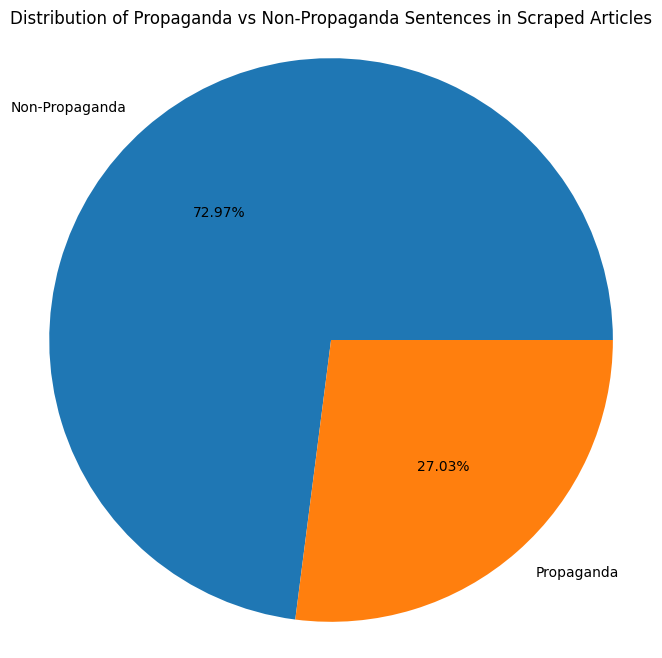

In [53]:
import matplotlib.pyplot as plt

# Get the counts
non_propaganda_count = len(unique_sentences_df[unique_sentences_df['label'] == 'non-propaganda'])
propaganda_count = len(unique_sentences_df[unique_sentences_df['label'] == 'propaganda'])

# Create pie chart
labels = ['Non-Propaganda', 'Propaganda']
sizes = [non_propaganda_count, propaganda_count]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.2f%%')
plt.title('Distribution of Propaganda vs Non-Propaganda Sentences in Scraped Articles')
plt.axis('equal')
plt.show()



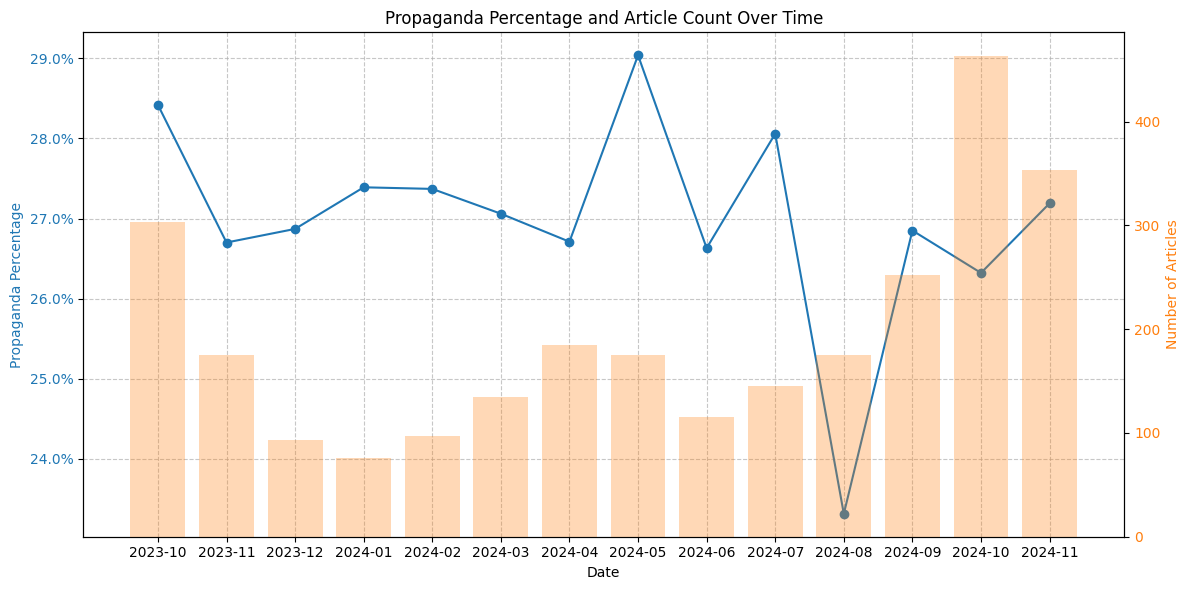

In [24]:
# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot propaganda percentage on primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Propaganda Percentage', color=color)
line = ax1.plot(monthly_propaganda.index[:-1], monthly_propaganda['propaganda_percentage'][:-1], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.7)

# Create second y-axis and plot article count as bars
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Number of Articles', color=color)
bars = ax2.bar(monthly_propaganda.index[:-1], monthly_propaganda['total_articles'][:-1], alpha=0.3, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Format percentage on primary y-axis
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))

plt.title('Propaganda Percentage and Article Count Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


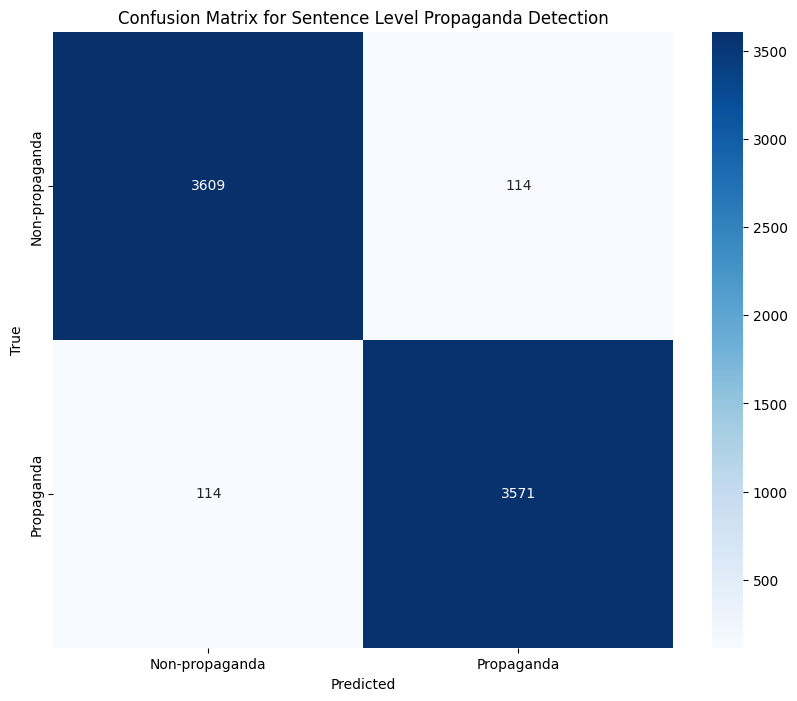

In [25]:
# Get predictions from your model
y_pred = model_slc.predict(X_test_slc)

# True labels are from your test set
y_true = y_test_slc

from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform the labels
y_true_binary = mlb.fit_transform(y_true)
y_pred_binary = mlb.transform(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true_binary.ravel(), y_pred_binary.ravel())

# Define the labels
labels = ['Non-propaganda', 'Propaganda']

# Create visualization with custom labels
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Sentence Level Propaganda Detection')
plt.show()
